# Introduction

In this notebook, we will try to understand, process and predict sales prices from the dataset NYC Property Sales from Kaggle.
The notebook is divided into four subsections: 
* Data inspection - We take a closer look at the data to see if it is usable, or has any unknown issues.
* Processing data - We use what we have learnt from the inspection, and start removing useless datapoints, outliers etc.
* Training ML algorithms - We try six different algorithms to predict the sales price
* Summary

You will need to have the "nyc-rolling-sales.csv" in the same folder as this notebook file.

#### Candidate numbers: 203, 237, 131.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read the dataset into pandas dataframe 
df = pd.read_csv("https://raw.githubusercontent.com/thomasRimmereide/INFO284-L5-G1/main/nyc-rolling-sales.csv",sep = ",", encoding="utf-8")

In [3]:
# Check what the dataframe consists of.
df.head()


,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


## Data Inspection:

In the dataset, there is plenty of values we want to remove for different reasons. We want to make sure the data to be used contains actual data, and as far as we can, avoid extremely high/low values. Furthermore, we will check the dataset for duplicates using a duplicated – method from pandas and delete them if there is any. Inspection of columns individually: 

#### BOROUGH: Want to utilize.

* This contains numbers representing a specific borough, being an area within New York, having values ranging from 1-5. As we can see later in the notebook, we simply transform these integers to strings to be able to one-hot-encode them later.
this columns looks useful to predict sales prices, so we use this.

#### TAX CLASS AT SALE: Want to utilize.
* This value represents what tax class the property had when it was sold, being represented by a number. Looking closer at these tax classes, we find that roughly 90% of them belong in tax classes 1 or 2 as shown below. We compare it to tax calss at present, but decide to only use the one mentioned above to avoid duplicates (both having the same tax class for the same properties).



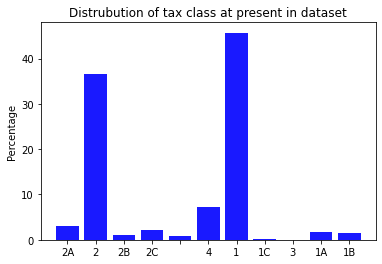

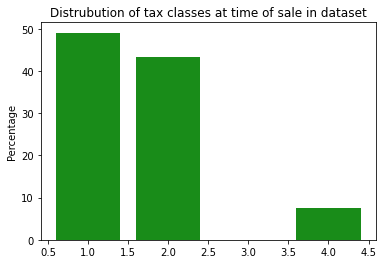

In [4]:
from collections import Counter
# Count how many of each in the columns
counter_for_present = Counter(df["TAX CLASS AT PRESENT"])
counter_for_time_of_sale = Counter(df["TAX CLASS AT TIME OF SALE"])

# Make them percentage of the total, instead of the number of each. 84548 is the total amount of rows
def f(v): return round((v/84548)*100,2)

# Apply the function to both dictonaries
d_present = dict((k, f(v)) for k, v in counter_for_present.items())
d_sale = dict((k, f(v)) for k, v in counter_for_time_of_sale.items())

# Extract keys and values from the dict to make the charts.
keys_present, values_present = d_present.keys() , d_present.values()
keys_sale, values_sale = d_sale.keys() , d_sale.values()

# Make one chart from each column

plt.bar(keys_present, values_present, align="center", alpha=0.9, color="b")
plt.ylabel("Percentage")
plt.title("Distrubution of tax class at present in dataset")
plt.show()


plt.bar(keys_sale, values_sale, align="center", alpha=0.9, color="g")
plt.ylabel("Percentage")
plt.title("Distrubution of tax classes at time of sale in dataset")
plt.show()


#### YEAR BUILT: Want to utilize.
* This column we believe will generally have an impact on the sales prices. In general, newer houses hold a higher value than older ones. Looking closer at the data, it seems like the dataset contains some values being 0, and also values ranging between 1100 - 1800. We do not want to include these in the prediction, so they will be removed later. As shown below, there is some spikes of buildings built in some particular years. Keeping this in mind, we attempt to use the column futher.


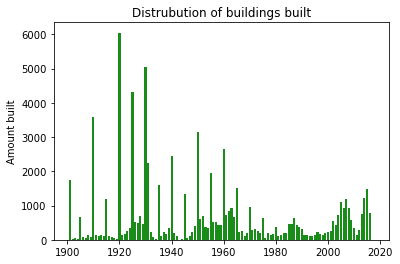

In [5]:
temp_df = df[(df["YEAR BUILT"] >1900) & (df["YEAR BUILT"] <2018)]
counter_year_built=Counter(temp_df["YEAR BUILT"])
keys, values = counter_year_built.keys(), counter_year_built.values()

plt.bar(keys, values, align="center", alpha=0.9, color="g")
plt.ylabel("Amount built")
plt.title("Distrubution of buildings built")
plt.show()

#### SALE DATE: Want to utilize
* This data contains a lot of data we can simplify. First thing we remove is the time(HMS), furthermore we want to split it into quarters instead of specific months and dates to look at a bigger general timespan. Doing this we can clearer see how the prices evolved from month to month, and each year.

#### BUILDING CLASS AT PRESENT and BUILDING CLASS AT TIME OF SALE: Do not want to utilize.
* Roughly 45% of the values exsists in the five classes with the most entries. Looking closer, there is a huge span of small sub-classes with 1-10 entries. Instead of using either of these columns we thought BUILDING CLASS CATEGORY looked better. It has understandable classes, but does also include quite a bit of smaller classes with very few entries.


In [6]:
print(df["BUILDING CLASS AT PRESENT"].value_counts())
print(df["BUILDING CLASS AT TIME OF SALE"].value_counts())

D4    12663
R4    12482
A1     6753
A5     5683
B2     4923
      ...  
I3        1
K8        1
R7        1
Q8        1
P7        1
Name: BUILDING CLASS AT PRESENT, Length: 167, dtype: int64
R4    12989
D4    12666
A1     6751
A5     5671
B2     4918
      ...  
HH        1
Q8        1
R7        1
I3        1
Y3        1
Name: BUILDING CLASS AT TIME OF SALE, Length: 166, dtype: int64


#### BUILDING CLASS CATEGORY: Want to utilize.
* Later in the notebook, we remove all entries containing less than 100 entries from this column to better see a pattern between what class a sale belongs to, and the price of the property.

#### EASE-MENT: Do not want to utilize.
* This is empty and will be dropped from the dataset.

#### BLOCK; LOT: Do not want to utilize
* These two describe in a smaller scale where the property is located. They might have an impact on the sales price, but include quite a large number of unique numbers. This time we choose to not focus on these.


#### NEIGHBORHOOD:  Do not want to utilize.
* This is a closer location of the property, down to what neighborhood it belongs to. Looking at the data, this column contains 254 different neighborhoods with some variation of properties sold, ranging from 3068 to 1, making it hard to utilize.
The data is spread around the different neighborhoods fairly evenly.



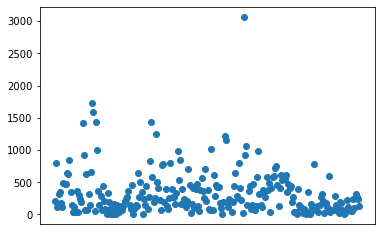

In [7]:
df["NEIGHBORHOOD"].value_counts()
counter_neighborhood=Counter(df["NEIGHBORHOOD"])
keys, values = counter_neighborhood.keys(), counter_neighborhood.values()

#Create a scatter, and do not include names of the neighborhoods
plt.scatter(keys, values)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
plt.show()

#### ADDRESS, APARTMENT NUMBER and ZIP_CODE: Do not want to utilize.
* These we consider quite useless for us, as the address has way too many unique values, and does not work as useful data to predict value. The apartment number has nothing to do with the actual value of the property, if any.

#### RESIDENTIAL UNITS: Do not want to utilize.
* The span of residential units goes from quite high (1844) all the way down to 0. We suspect the 0-cases might be office buildings. For now, we will drop this, but it might become useful later to group all the niche numbers of residential units (For example 100-500 units) together to find if there is any correlation to the predicted price. For now, we drop this column



In [8]:
# Highest amount of redidential units in the column
max(df["RESIDENTIAL UNITS"].value_counts().keys())

1844

#### COMMERCIAL UNITS and TOTAL UNITS: Do not want to utilize.
* Like residential units, this shows if the property has any units for commercial use. We chose to not use these data, partly because roughly 94% of the data is 0. This might not be completely true because we have seen that properties can also have both, and neither of them. Total units are quite similar, and could be used later in the project, but is on hold for this time.

In [9]:
print("Total datapoints: "+ str(len(df["COMMERCIAL UNITS"])))
print("Amount of data being zero: " + str(df["COMMERCIAL UNITS"].value_counts()[0]))
print("Percentage of data being zero: " + str(round((df["COMMERCIAL UNITS"].value_counts()[0])/
                                                 (len(df["COMMERCIAL UNITS"]))*100,2)) + "%")


Total datapoints: 84548
Amount of data being zero: 79429
Percentage of data being zero: 93.95%


#### LAND SQUARE FEET and GROSS SQUARE FEET: Want to utilize GROSS.
* These data look hard to use, as around 43-47% of the data has no value. We are not sure how big the overlap of these two columns is, so the percentage might be even higher. This leaves quite a large amount of data available out. Despise this, gross square feet generally have a great correlation to sales price. We will attempt to utilize this in our ML to check how it performs.

In [10]:
lqf=df["LAND SQUARE FEET"].value_counts()
gqf=df["GROSS SQUARE FEET"].value_counts()
print("Amount of 'Land square feet' being either zero or none: " + str(round((sum(lqf[:2])/
                                                                              len(df["LAND SQUARE FEET"])*100),2)) + "%")
print("Amount of 'Gross square feet' being either zero or none: " + str(round((sum(gqf[:2])/
                                                                              len(df["GROSS SQUARE FEET"])*100),2)) + "%")

Amount of 'Land square feet' being either zero or none: 43.26%
Amount of 'Gross square feet' being either zero or none: 46.16%


#### SALE PRICE: Target
* There are some values here we do not want to have, including 1, 10 and 500 which there is a lot of. There are also 0 values, being explained in the data set as properties that has either been passed down to for example their children, or transfer of deeds between parties. We drop these values from the dataset.

### Preprossesing data 
To avoid having null, "-", 0 etc datapoints, we want to get rid of them and focus on actual data. For this, a few functions used with the .apply function from pandas, we aim to clean up the roughest parts of the data


* We remove outliers from SALE PRICE because these prices are unrealistic.
* TAX CLASS AT PRESENT contains rows with empty cells. These are removed from both TAX CLASS AT PRESENT and BOROUGH.
* BOROUGH is an categorical value. Pandas get.dummies dont treat integers as categorical, hence we need to convert BOROUGH    from int to str type.
* SALE DATE is to detailed. The differens in prices can only be seen in month and year. Therfore we split SALE DATE into      two new columns SALE DATE YEAR and SALE DATE MONTH and remove the SALE DATE column.
* With the column containing YEAR BUILT we want the data to only range from 1900-2017.  


In [11]:
df.drop(columns=["Unnamed: 0", "BLOCK", "LOT", "EASE-MENT", "ADDRESS", "APARTMENT NUMBER"
    ,"BUILDING CLASS AT PRESENT", "BUILDING CLASS AT TIME OF SALE", "NEIGHBORHOOD","ZIP CODE",
                 "TAX CLASS AT PRESENT","RESIDENTIAL UNITS","COMMERCIAL UNITS","TOTAL UNITS", "LAND SQUARE FEET"
                 ], inplace = True)

In [12]:
# Check the dataframe again to check whats left after the drop
df.head()

,BOROUGH,BUILDING CLASS CATEGORY,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,07 RENTALS - WALKUP APARTMENTS,6440,1900,2,6625000,2017-07-19 00:00:00
1,1,07 RENTALS - WALKUP APARTMENTS,18690,1900,2,-,2016-12-14 00:00:00
2,1,07 RENTALS - WALKUP APARTMENTS,7803,1900,2,-,2016-12-09 00:00:00
3,1,07 RENTALS - WALKUP APARTMENTS,6794,1913,2,3936272,2016-09-23 00:00:00
4,1,07 RENTALS - WALKUP APARTMENTS,4615,1900,2,8000000,2016-11-17 00:00:00


Before continuing the processing of the data, we want to check how many unique values each of them contains, to check
if any of them need to be grouped up or categorized any more for the data to be able to give us any information.

We already know some of them will contain a large amount of unique values, like sale price and sale date. These will
be greatly reduced to increase the chance of extracting any trends from them.

Also, for the algorithms to be efficient, there is a limit to how many parameters it would make sense to use as input.

In [13]:
# Check how many unique values our initial columns consists of.
print("BOROUGH:                        " + str(df['BOROUGH'].nunique()))
print("YEAR BUILT:                     "+ str(df['YEAR BUILT'].nunique()))
print("TAX CLASS AT TIME OF SALE:      "+ str(df['TAX CLASS AT TIME OF SALE'].nunique()))
print("SALE PRICE:                     "+ str(df['SALE PRICE'].nunique()))
print("SALE DATE:                      "+ str(df['SALE DATE'].nunique()))

BOROUGH:                        5
YEAR BUILT:                     158
TAX CLASS AT TIME OF SALE:      4
SALE PRICE:                     10008
SALE DATE:                      364


In [14]:
# Collection of functions used for cleanup
def remove_unwanted_entries(dataframe):
    for column in df.columns:
        dataframe = dataframe[dataframe[column] != ' -  ']
        dataframe = dataframe[dataframe[column] != ' ']
        dataframe = dataframe[dataframe[column] != 'nan']
    return dataframe


def split_sale_date(dataframe):
    if "SALE DATE" in dataframe:
        dataframe["SALE DATE"] = pd.to_datetime(dataframe["SALE DATE"])
        dataframe["SALE DATE YEAR"] = dataframe["SALE DATE"].dt.year
        dataframe["SALE DATE MONTH"] = dataframe["SALE DATE"].dt.month
        dataframe = dataframe.drop(columns=["SALE DATE"])
        return dataframe


def make_float(columns : list, dataframe):
    for column in columns:
        dataframe[column] = dataframe[column].astype("float64")
    return dataframe

# Code from: https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
def outliers(columns : list, dataframe):
    for column in columns:
        q_low = dataframe[column].quantile(0.01)
        q_hi  = dataframe[column].quantile(0.99)
        dataframe = dataframe[(dataframe[column] < q_hi) & (dataframe[column] > q_low)]
    return dataframe


def toString(columns : list, dataframe):
    for column in columns:
        dataframe[column] = dataframe[column].astype(str)
    return dataframe



In [15]:
print("Amount of rows in dataframe before the cleaning: " + str(len(df)))

Amount of rows in dataframe before the cleaning: 84548


In [16]:
df.head()

,BOROUGH,BUILDING CLASS CATEGORY,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,07 RENTALS - WALKUP APARTMENTS,6440,1900,2,6625000,2017-07-19 00:00:00
1,1,07 RENTALS - WALKUP APARTMENTS,18690,1900,2,-,2016-12-14 00:00:00
2,1,07 RENTALS - WALKUP APARTMENTS,7803,1900,2,-,2016-12-09 00:00:00
3,1,07 RENTALS - WALKUP APARTMENTS,6794,1913,2,3936272,2016-09-23 00:00:00
4,1,07 RENTALS - WALKUP APARTMENTS,4615,1900,2,8000000,2016-11-17 00:00:00


In [17]:
# Dataset clean-up
values_to_float=["YEAR BUILT","SALE PRICE", "GROSS SQUARE FEET"]
enitries_to_str = ["BOROUGH","TAX CLASS AT TIME OF SALE"]
df = remove_unwanted_entries(df)
df = split_sale_date(df)
df = make_float(values_to_float, df)
df = toString(enitries_to_str, df)

df = df[df["SALE PRICE"] > 10]
df = df[df["GROSS SQUARE FEET"] > 1]
df = df[df["YEAR BUILT"] >= 1900]
df = outliers(["SALE PRICE", "GROSS SQUARE FEET"], df)
df.dropna(inplace=True)



In [18]:
print("Amount of rows in dataframe after the cleaning: " + str(len(df)))

Amount of rows in dataframe after the cleaning: 26404


By removing some "useless" data, dataframe was reduced by 58 144 datapoints. 

* Some of the columns in the dataframe contains categorical data. We use pandas get_dummies to create dummie features, so       that the data is possible to use in the machine learning algorithm in a proper way. 

In [19]:
# Creating OneHotEncoded values for discrete columns
df = pd.get_dummies(df, columns=["BOROUGH", "TAX CLASS AT TIME OF SALE",
                                 "BUILDING CLASS CATEGORY"
                                 ])

#Removing BUILDING CLASS CATEGORY with less than 100 entries.
for i in df.columns:
    count= 0
    if "BUILDING" in i:
        for x in df[i]:
            if x ==1:
                count+=1
        if count < 100:
            df = df.drop(columns=i)

### Training ML algorithms

Below, we train the following algorithms to compare the results and find the best optimalized for this particular dataset we have processed:
* Ridge 
* Linear Regression
* MLP Regressor
* Lasso
* Random Forest

For Ridge and Lasso, we used Grid Search with Cross-Validation. Instead of using Simple Grid Search, which uses one single split and depending on how the data is split. 
The difference between the two is the amount of splits we do on the dataset. We decided to use KFold to do the folding on the dataset, and use different amount of splits for each algorithm. This is explained in (p.263-270)

Grid Search can be explained as nested for-loops checking every possible combination of parametres you give it. So the amount of models the program would need to train is amount_of_unique_combinations_of_parameters * amounts_of_folds. This can quickly escalate to a lot of models to train, which will take a large amount of time to run. The positive about this method is that you do not manually have to go through different parametres to find best score, and once it has ran once you do not have to run it again.


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from matplotlib import pyplot as plt 
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score as cvs
from sklearn.model_selection import KFold
import math
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso


In [21]:
target = df["SALE PRICE"]
data = df.drop("SALE PRICE", axis=1)

data.head()

,GROSS SQUARE FEET,YEAR BUILT,SALE DATE YEAR,SALE DATE MONTH,BOROUGH_1,BOROUGH_2,BOROUGH_3,BOROUGH_4,BOROUGH_5,TAX CLASS AT TIME OF SALE_1,...,TAX CLASS AT TIME OF SALE_4,BUILDING CLASS CATEGORY_01 ONE FAMILY DWELLINGS,BUILDING CLASS CATEGORY_02 TWO FAMILY DWELLINGS,BUILDING CLASS CATEGORY_03 THREE FAMILY DWELLINGS,BUILDING CLASS CATEGORY_07 RENTALS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY_14 RENTALS - 4-10 UNIT,BUILDING CLASS CATEGORY_21 OFFICE BUILDINGS,BUILDING CLASS CATEGORY_22 STORE BUILDINGS,BUILDING CLASS CATEGORY_29 COMMERCIAL GARAGES,BUILDING CLASS CATEGORY_30 WAREHOUSES
0,6440.0,1900.0,2017,7,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,6794.0,1913.0,2016,9,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,4615.0,1900.0,2016,11,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,4226.0,1920.0,2016,9,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9,18523.0,1920.0,2016,11,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Linear Regression

For Linear Regression, we used Cross-Validation with KFold to check if it works better than the original scoring method.


In [22]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(data,target, random_state = 12)


feature_scaler = StandardScaler()
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)


linreg=LinearRegression()
linreg.fit(X_train, y_train)

print("Linear Regression score method:")
print("Train score ",str(round(linreg.score(X_train, y_train)*100,2)) + "%")
print("Test score " ,str(round(linreg.score(X_test, y_test)*100,2)) + "% \n")

kfold = KFold(n_splits=11,shuffle=True,random_state=0)
score = cvs(linreg, data, target,cv = kfold)

print("Linear Regression with Cross Validation")
print("Cross Validation mean score ",round(score.mean()*100,2),"%" )
print("Standard deviation ", round(score.std()*100,2))

Linear Regression score method:
Train score  59.05%
Test score  60.7% 

Linear Regression with Cross Validation
Cross Validation mean score  59.15 %
Standard deviation  2.2


#### Ridge
For Cross-Validation we tested kFold with splits from 2 to 200. 7 gives one of the best mean scores (59.03) while keeping the STD low 1.9.

For Ridge we tested alpha between 0 and 199 with 0.5 between each number. 21 gave the best score.



In [23]:
parameter_ridge = {"alpha" : [i for i in np.arange(2,200,0.5)] }
X_train, X_test, y_train, y_test = train_test_split(data,target, random_state = 12)


ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train)
kfold = KFold(n_splits=7,shuffle=True,random_state=0)

score = cvs(ridge, data, target,cv = kfold)
print("Ridge cross validation")
print("RIDGE R^2 mean score ", round(score.mean()*100,2), "%")
print("Standard deviation ", round(score.std()*100,2),"\n")


gs = GridSearchCV(Ridge(), parameter_ridge, cv=kfold)
gs.fit(X_train, y_train)
print("Ridge grid search with cross validation ")
print("Best parameters ",gs.best_params_)
print("Best train score ",round(gs.best_score_*100,2),"%")
print("Test score ", round(gs.score(X_test, y_test)*100,2),"%")

Ridge cross validation
RIDGE R^2 mean score  59.03 %
Standard deviation  1.9 

Ridge grid search with cross validation 
Best parameters  {'alpha': 21.0}
Best train score  58.49 %
Test score  60.74 %


#### Lasso
When testing CVS with different folds. The score i quit similar, but the STD seems to increase when nuber of folds increse. a three fold seems to be the best fit for this dataset.
When doing a gridsearch, it looks like the bigger alpha, the better. Here we test between 0-0.9.  


In [24]:
X_train, X_test, y_train, y_test = train_test_split(data,target, random_state = 12)

feature_scaler = StandardScaler()
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

# standard lasso 
lasso = Lasso(alpha = 1, max_iter = 100000).fit(X_train,y_train)
print("Standard Lasso ")
print("Number of fetures used " ,np.sum(lasso.coef_ != 0))
print("Train score ", round(lasso.score(X_train, y_train)*100,2))
print("Test score ", round(lasso.score(X_test, y_test)*100,2))
    

kfold = KFold(n_splits=3,shuffle=True,random_state=0)
score = cvs(Lasso(max_iter = 100000), data, target,cv = kfold)
print("Lasso cross validation")
print("Lasso R^2 mean score ", round(score.mean()*100,2), "%")
print("Standard deviation ", round(score.std()*100,2),"\n")

lasso = Lasso(max_iter= 100000)
parameter_lasso = {"alpha" : [i for i in np.arange(0,1,0.1)] }
gs = GridSearchCV(lasso, parameter_lasso, n_jobs =-1, cv=3)
gs.fit(X_train, y_train)
print("Lasso grid search with cross validation ")
print("Best parameters ",gs.best_params_)
print("Best train score ",round(gs.best_score_*100,2),"%")
print("Test score ", round(gs.score(X_test, y_test)*100,2),"%")

Standard Lasso 
Number of fetures used  19
Train score  59.05
Test score  60.7


KeyboardInterrupt: 

#### MLPRegressor
For This algorithm we will scale our data with the MinMaxScaler. Our data set has a wide range of values for different feature. Espacially the sales price we want to predict. That's why we will use MinMaxScaler to scale the data into values between 1 and -1
After trying a few different models with various numbers of hidden layers and nodes in each layer. Each resulting in a number of different results and runtime. We found that one hidden layer with 5 nodes gave us the best result. 
The solver 'lbfgs' worked best for our dataset, giving the highest score. 


In [27]:
#Importing sklearns Mulitlayered-Perceptron Regressor and MinMax scaler
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Preparing the data for MLP-regression

In [28]:
X =df.drop(['SALE PRICE'], axis=1).values
y =df.iloc[:, 2].values

#Creating a scaler
scaler = MinMaxScaler()                    
#Scaling the data
scaled_data = scaler.fit_transform(X,y) 


In [ ]:
#Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

#Creating our MLPRegressor 
nn = MLPRegressor(hidden_layer_sizes = [5,], activation = 'relu', alpha=0.001, max_iter =10000, solver='lbfgs')

#Fitting the data
nn.fit(X_train, y_train)
print("Neural Network Scores")
print("Train score: ", str(round(nn.score(X_train, y_train)*100,2)) + "%")
print("Test score:  ", str(round(nn.score(X_test, y_test)*100,2)) + "%")


It seems that the Network score lands on approximately 50% dataset. 
It could mean that we have a number of features that are not fitting well in the algorithm. That the functions that try to fit all features best possible,  makes the accuracy on our target feature (Sales price) lower.

#### Random Forrest

Due to the nature of decision trees there is no need for us to scale data any further. The forest classifier will clasify the features and their values. The trees will simply split the features as they are, making the trees in the forest.


We import and use sklearn.ensamble RandomForestClassifier to ensamble our forest.

In [30]:
from sklearn.ensemble import RandomForestClassifier   

Seperating data for features and salesprice, and splitting the with train_test_split

In [31]:
X =df.drop(['SALE PRICE'], axis=1)
y =df.iloc[:, 2].values
#Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 12)

We create an instance of a forrest with 12 trees. Due to the size of our dataset we would get a memory error when trying to run the .fit function on our forest. Trying to reduce features to allow more trees led to a lower score on the algorithm.  

In [ ]:
#Creating a random forest
r_For = RandomForestClassifier(n_estimators=12, bootstrap = True, max_features = 'auto') 
#Fitting data into the forest
r_For.fit(X,y)
#Printing test and training scores
print("Random forest test score: ", str(round(r_For.score(X_test, y_test)*100,2)) + "%")
print("Random forest train score: ", str(round(r_For.score(X_train, y_train)*100,2)) + "%")

Random forest test score:  92.86%


We get a score of above 90% on our random forest algorithm. It seems that trees to split features an values makes for a good prediction algorithm on our dataset. The forest randomly assigns features to trees to find the ones that allows for the best predictions. This is what makes it the most precise algorithm for our dataset. 


We can now calculate the importance of the features i.e how relevent they were for the predcitions. Each feature is assigned to a number between 0-1. Closer to 1 the feature is the more relevent it is for the predicition

In [ ]:
#Calculating the feature importance
print(r_For.feature_importances_)

#Visualization of feature importance
plt.barh(X.columns, r_For.feature_importances_)

Here we see how the importance i.e how well different features predict the salesprice. We can see that a few features score very low. 

The forest randomly tested features on different trees to find, and use the most relevant ones for predicting sales price. We could reason that the other algorithms used features that would be misleading. For an instance MLPRegressor used all features after cleaning of the dataset. 
Trying to create a function that would try to fit all features best possible made it less precise in predicting salesprice.


### Summary

#### Ridge: 
* Ridge cross validation
      RIDGE R^2 mean score  59.03 %
      Standard deviation  1.9 

* Ridge grid search with cross validation 
      Best parameters  {'alpha': 21.0}
      Best train score  58.49 %
      Test score  60.74 %
          

* Linear Regression: 
* MLP Regressor: 
* Lasso: 
* Random Forest:
